# Human Genome Annotation Analysis
### Contributors
- Go, Daphne Janelyn
- Gilo, Joshua
- Lasala, Kyle Carlo

### Notebook Version Control

In [ ]:
!pip install nbdime

In [6]:
# Version Check
!nbdiff-web Bioinformatics_Ex1.ipynb https://raw.githubusercontent.com/KyleCarlo/gene-annotation-analysis-of-human-genome/refs/heads/main/Bioinformatics_Ex1.ipynb

^C


In [7]:
# Merging
!nbmerge-web Bioinformatics_Ex1.ipynb Bioinformatics_Ex1.ipynb https://raw.githubusercontent.com/KyleCarlo/gene-annotation-analysis-of-human-genome/refs/heads/main/Bioinformatics_Ex1.ipynb --out merged.ipynb

^C


# Central dogma of molecular biology in our own cells

## Part 1. Human genome, transcriptome, proteome

There are multiple resources listed towards the bottom of this page, which provide information about the human genome. For example, you can download information about the human genome, transcriptome, and proteome from RefSeq or from GENCODE.

Using these resources, report on the following questions:

1. **How many genes are there in the human genome?**
2. **How many transcripts are there in the human transcriptome?**
3. **What are the different kinds/classes of RNA present in the human transcriptome?**
4. **How many protein-coding genes are there in the human genome?**
5. **How many proteins are there in the human proteome?**
6. **Plot the distribution of lengths of genes.**
7. **Plot the distribution of the length of exons.**
8. **Plot the distribution of the length of introns.**

## Prerequisites: Downloading the necessary data and importing the libraries.

In [ ]:
# gffutils for reading gtf
!pip install gffutils

In [3]:
import gffutils
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
import urllib.request
import os
import gzip
import shutil

urls = {
    "gencode.v48.annotation.gtf.gz":
        "ftp://ftp.ebi.ac.uk/pub/databases/gencode/"
        "Gencode_human/release_48/gencode.v48.annotation.gtf.gz",

    "GCF_000001405.40_GRCh38.p14_genomic.gtf.gz":
        "https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/001/405/"
        "GCF_000001405.40_GRCh38.p14/GCF_000001405.40_GRCh38.p14_genomic.gtf.gz"
}

for filename, url in urls.items():
    if os.path.exists(filename):
        print(f"{filename} already exists, skipping download.")
    else:
        print(f"Downloading {filename} ...")
        urllib.request.urlretrieve(url, filename)
        print(f"Saved to {filename}")

for fn in urls:
    out_fn = fn[:-3]
    if os.path.exists(out_fn):
        print(f"{out_fn} already exists, skipping decompression.")
    else:
        print(f"Decompressing {fn} to {out_fn} ...")
        with gzip.open(fn, 'rb') as f_in, open(out_fn, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)
        print(f"Decompressed to {out_fn}")
        os.remove(fn)


Saved to gencode.v48.annotation.gtf.gz
Saved to GCF_000001405.40_GRCh38.p14_genomic.gtf.gz
gencode.v48.annotation.gtf already exists, skipping decompression.
GCF_000001405.40_GRCh38.p14_genomic.gtf already exists, skipping decompression.


### Creating a DB for GTF files

In [ ]:
gencode_file = 'gencode.v48.annotation.gtf'
db_file = 'gencode.db'
gencode_db = gffutils.create_db(gencode_file, dbfn=db_file, disable_infer_genes=True, disable_infer_transcripts=True, force=True, keep_order=True, merge_strategy='merge', sort_attribute_values=True)

In [5]:
refseq_file = 'GCF_000001405.40_GRCh38.p14_genomic.gtf'
db_file = 'refseq.db'
refseq_db = gffutils.create_db(refseq_file, dbfn=db_file, disable_infer_genes=True, disable_infer_transcripts=True, force=True, keep_order=True, merge_strategy='merge', sort_attribute_values=True)

### Reading GTF DB

In [2]:
db_file = 'gencode.db'
gencode = gffutils.FeatureDB(db_file)

In [6]:
db_file = 'refseq.db'
refseq = gffutils.FeatureDB(db_file)

### How many genes are there in the human genome?

Frankish, A., Uszczynska, B., Ritchie, G.R. et al. Comparison of GENCODE and RefSeq gene annotation and the impact of reference geneset on variant effect prediction. BMC Genomics 16 (Suppl 8), S2 (2015). https://doi.org/10.1186/1471-2164-16-S8-S2

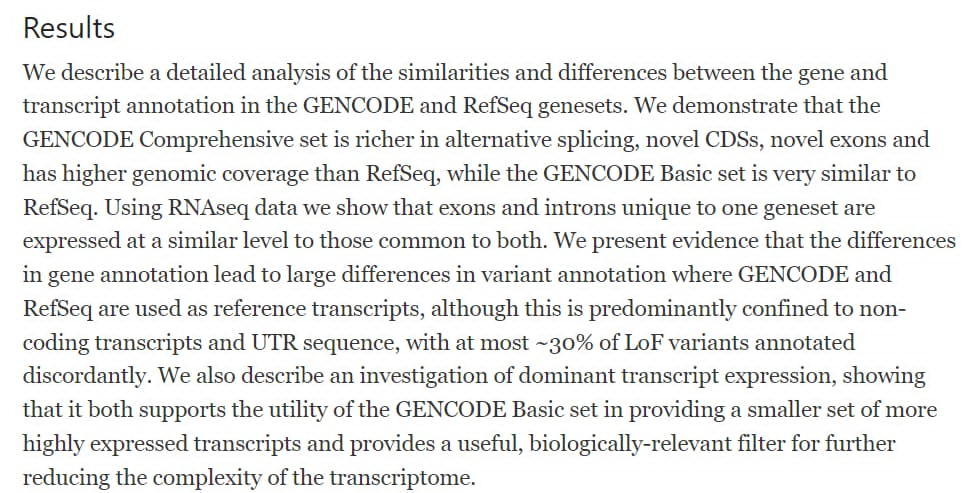

Data Source: GENCODE

In [34]:
cursor = gencode.conn.execute("""
    SELECT COUNT(DISTINCT id) FROM features
    WHERE featuretype='gene';
""")

cursor.fetchall()[0][0]

78686

Without Pseudogenes

In [108]:
cursor = gencode.conn.execute("""
    SELECT COUNT(DISTINCT id) FROM features
    WHERE json_extract(attributes, '$.gene_type') NOT LIKE '%pseudogene%'
    AND featuretype='gene'
""")

cursor.fetchall()[0][0]

63494

Data Source: RefSeq

In [19]:
cursor = refseq.conn.execute("""
    SELECT COUNT(DISTINCT json_extract(attributes, '$.gene')) FROM features;
""")

refseq_gene_count = cursor.fetchall()[0][0]
print(refseq_gene_count)

59701


Without pseudogenes

In [20]:
cursor = refseq.conn.execute("""
    SELECT COUNT(DISTINCT json_extract(attributes, '$.gene')) FROM features
    WHERE json_extract(attributes, '$.pseudo')='["true"]';
""")

print(refseq_gene_count - cursor.fetchall()[0][0])

42622


### How many transcripts are there in the human transcriptome?

Data Source: GENCODE

In [22]:
cursor = gencode.conn.execute("""
    SELECT COUNT(DISTINCT id) FROM features 
    WHERE featuretype='transcript';
""")

cursor.fetchall()[0][0]

385669

Data Source: RefSeq (NCBI)

In [23]:
cursor = refseq.conn.execute("""
    SELECT COUNT(DISTINCT id) FROM features 
    WHERE featuretype='transcript';
""")

cursor.fetchall()[0][0]

201189

### What are the different kinds/classes of RNA present in the human transcriptome?

Data Source: GENCODE

In [30]:
cursor = gencode.conn.execute("""
    SELECT DISTINCT json_extract(attributes, '$.gene_type') FROM features
    WHERE json_extract(attributes, '$.gene_type') LIKE '%RNA%'
""")

for each in cursor.fetchall():
    for each_2 in each:
        print(each_2)

["lncRNA"]
["miRNA"]
["snRNA"]
["misc_RNA"]
["snoRNA"]
["scaRNA"]
["rRNA_pseudogene"]
["rRNA"]
["sRNA"]
["vault_RNA"]
["Mt_tRNA"]
["Mt_rRNA"]


Data Source: RefSeq (NCBI)

In [33]:
cursor = refseq.conn.execute("""
    SELECT DISTINCT json_extract(attributes, '$.transcript_biotype') FROM features
    WHERE json_extract(attributes, '$.transcript_biotype') LIKE '%RNA%'
""")

for each in cursor.fetchall():
    for each_2 in each:
        print(each_2)

["miRNA"]
["lnc_RNA"]
["mRNA"]
["snRNA"]
["snoRNA"]
["ncRNA"]
["antisense_RNA"]
["tRNA"]
["rRNA"]
["telomerase_RNA"]
["vault_RNA"]
["Y_RNA"]
["RNase_MRP_RNA"]
["scRNA"]
["RNase_P_RNA"]


### How many protein-coding genes are there in the human genome?

Data Source: GENCODE

In [42]:
cursor = gencode.conn.execute("""
    SELECT COUNT(DISTINCT json_extract(attributes, '$.gene_id')) FROM features 
    WHERE json_extract(attributes, '$.gene_type')='["protein_coding"]'
    AND json_extract(attributes, '$.tag') NOT LIKE '%read%';
""")

cursor.fetchall()[0][0]

19452

Data Source: RefSeq (NCBI)

In [47]:
cursor = refseq.conn.execute("""
    SELECT COUNT(DISTINCT json_extract(attributes, '$.gene')) FROM features 
    WHERE json_extract(attributes, '$.gene_biotype')='["protein_coding"]'
""")

cursor.fetchall()[0][0]

20078

### How many proteins are there in the human proteome?

Data Source: GENCODE

In [50]:
cursor = gencode.conn.execute("""
    SELECT COUNT(DISTINCT json_extract(attributes, '$.protein_id')) FROM features;
""")

cursor.fetchall()[0][0]

112346

Data Source: RefSeq (NCBI)

In [51]:
cursor = refseq.conn.execute("""
    SELECT COUNT(DISTINCT json_extract(attributes, '$.protein_id')) FROM features;
""")

cursor.fetchall()[0][0]

136282

### Plot the distribution of lengths of genes.

Data Source: GENCODE

In [4]:
query = """
    SELECT featuretype, SUBSTRING(json_extract(attributes, '$.transcript_id'), 3, LENGTH(json_extract(attributes, '$.transcript_id'))-4), start, end FROM features;
"""
gencode_df = pd.read_sql(query, gencode.conn)
gencode_df.columns = ['type', 'transcript_id', 'start', 'end']
gencode_df['length'] = gencode_df['end'] - gencode_df['start']

In [5]:
gencode_df[gencode_df["type"]=="gene"][['start', 'end', 'length']].describe()

,start,end,length
count,7.868600e+04,7.868600e+04,7.868600e+04
mean,7.474854e+07,7.477998e+07,3.143851e+04
std,5.588770e+07,5.589030e+07,8.614636e+04
min,5.770000e+02,6.470000e+02,7.000000e+00
25%,3.038022e+07,3.040348e+07,7.610000e+02
50%,6.218170e+07,6.220718e+07,4.596000e+03
75%,1.104158e+08,1.104551e+08,2.596550e+04
max,2.489366e+08,2.489371e+08,2.473538e+06


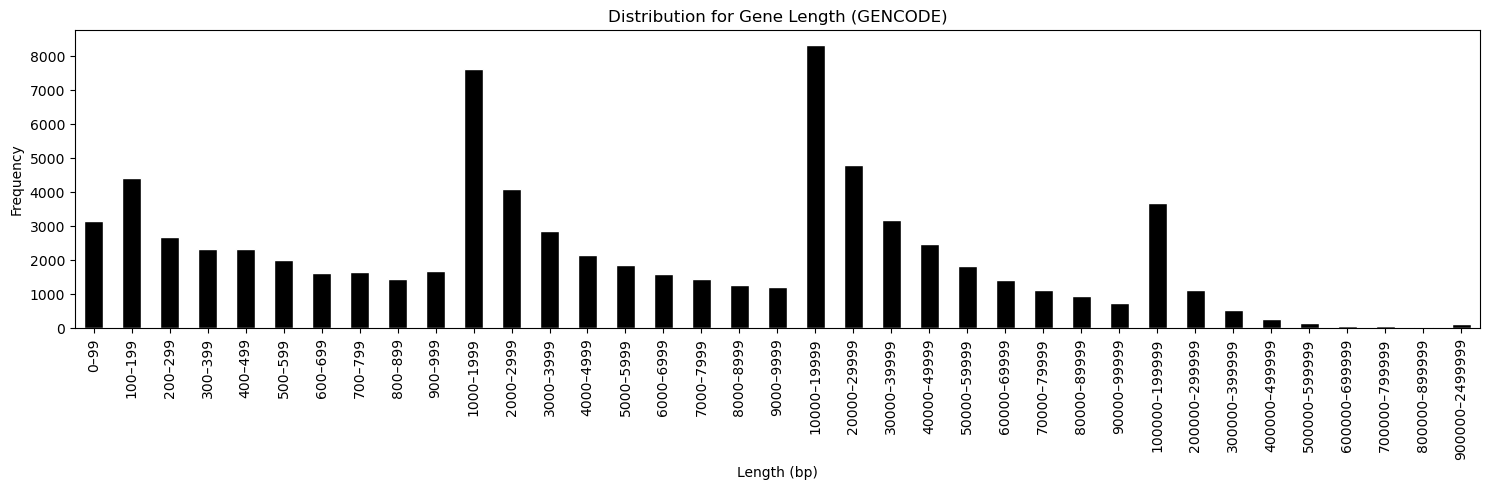

In [6]:
# DONE JUST NOT RAN IN GENCODE
gene_lengths = gencode_df[gencode_df['type'] == 'gene']['length']

bin_edges = (
    list(range(0, 1000, 100)) +
    list(range(1000, 10000, 1000)) +
    list(range(10000, 100000, 10000)) +
    list(range(100000, 1000000, 100000)) +
    [2500000]
)
bin_labels = [f"{bin_edges[i]}–{bin_edges[i+1]-1}" for i in range(len(bin_edges)-1)]

binned = pd.cut(gene_lengths, bins=bin_edges, labels=bin_labels, right=True)

bin_counts = binned.value_counts(sort=False)

plt.figure(figsize=(15, 5))
bin_counts.plot(kind='bar', color='black', edgecolor='white')
plt.xlabel("Length (bp)")
plt.ylabel("Frequency")
plt.title("Distribution for Gene Length (GENCODE)")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [7]:
min(gene_lengths), max(gene_lengths)

(7, 2473538)

Data Source: RefSeq (NCBI)

In [8]:
query = """
    SELECT featuretype, SUBSTRING(json_extract(attributes, '$.transcript_id'), 3, LENGTH(json_extract(attributes, '$.transcript_id'))-4), start, end FROM features;
"""
refseq_df = pd.read_sql(query, refseq.conn)
refseq_df.columns = ['type', 'transcript_id', 'start', 'end']
refseq_df['length'] = refseq_df['end'] - refseq_df['start']

In [9]:
refseq_df[refseq_df['type'] == 'gene'][['start', 'end', 'length']].describe()

,start,end,length
count,6.742900e+04,6.742900e+04,6.742900e+04
mean,6.600083e+07,6.602978e+07,2.894632e+04
std,5.792598e+07,5.793032e+07,8.293749e+04
min,1.000000e+00,1.070000e+02,7.000000e+00
25%,1.834998e+07,1.837848e+07,8.990000e+02
50%,5.159851e+07,5.162277e+07,5.292000e+03
75%,1.029000e+08,1.029508e+08,2.268400e+04
max,2.489366e+08,2.489371e+08,2.473619e+06


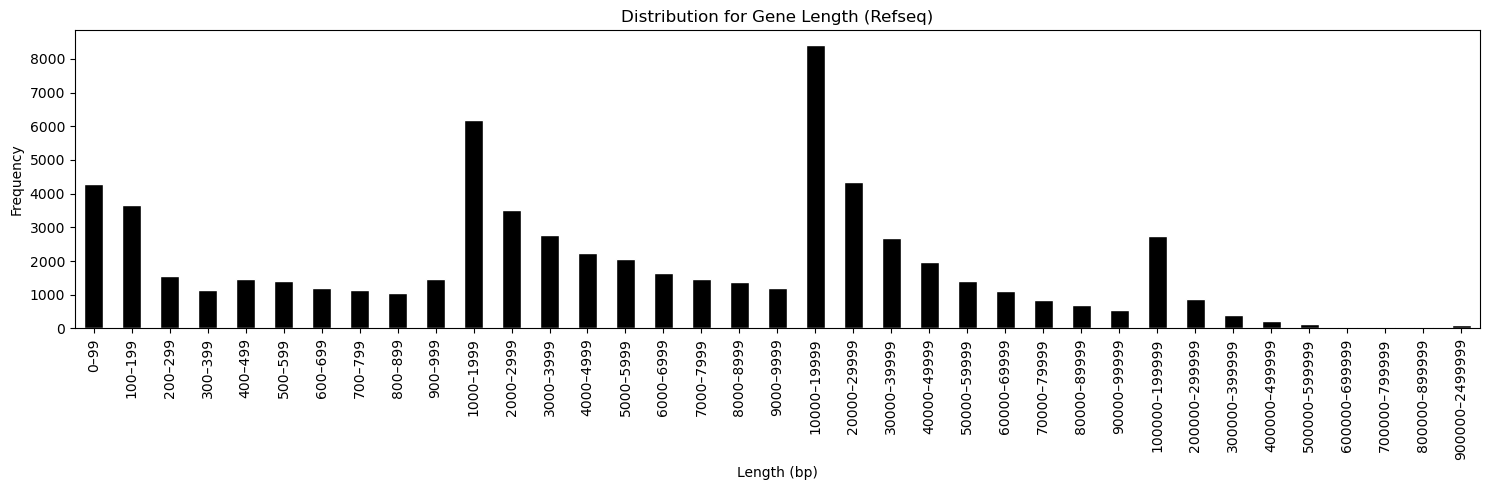

In [10]:
gene_lengths = refseq_df[refseq_df['type'] == 'gene']['length']
bin_edges = (
    list(range(0, 1000, 100)) +
    list(range(1000, 10000, 1000)) +
    list(range(10000, 100000, 10000)) +
    list(range(100000, 1000000, 100000)) +
    [2500000]
)
bin_labels = [f"{bin_edges[i]}–{bin_edges[i+1]-1}" for i in range(len(bin_edges)-1)]

binned = pd.cut(gene_lengths, bins=bin_edges, labels=bin_labels, right=True)

bin_counts = binned.value_counts(sort=False)

plt.figure(figsize=(15, 5))
bin_counts.plot(kind='bar', color='black', edgecolor='white')
plt.xlabel("Length (bp)")
plt.ylabel("Frequency")
plt.title("Distribution for Gene Length (Refseq)")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [11]:
min(gene_lengths), max(gene_lengths)

(7, 2473619)

### Plot the distribution of the length of exons.

Data Source: GENCODE

In [12]:
gencode_df[(gencode_df['length'] == 0) & (gencode_df['type'] == 'exon')]

,type,transcript_id,start,end,length
19758,exon,ENST00000648684.1,2768091,2768091,0
692446,exon,ENST00000441168.6,240524381,240524381,0
833784,exon,ENST00000497811.6,107855313,107855313,0
862212,exon,ENST00000634941.2,127499730,127499730,0
907564,exon,ENST00000476999.6,161105235,161105235,0
1244745,exon,ENST00000514657.2,122722214,122722214,0
1347879,exon,ENST00000664259.1,19753084,19753084,0
1681886,exon,ENST00000666128.1,110511060,110511060,0
1734511,exon,ENST00000665256.1,153412091,153412091,0
2003328,exon,ENST00000659571.1,113111410,113111410,0


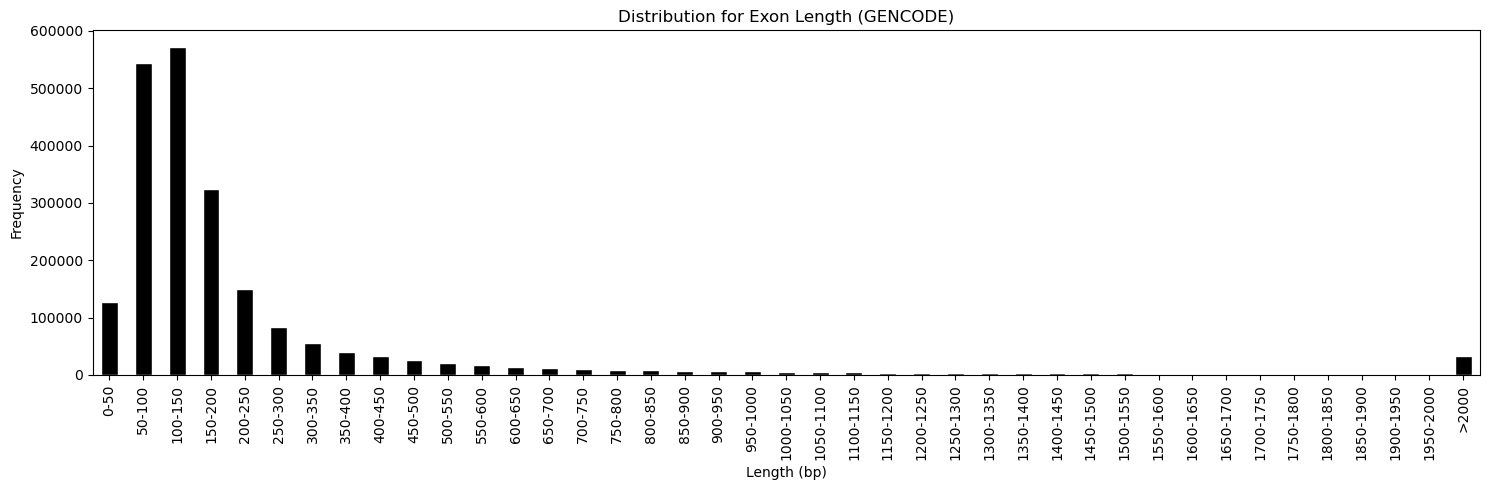

In [13]:
# DONE JUST NOT RAN IN COLAB
exon_lengths = gencode_df[gencode_df['type'] == 'exon']['length']

bin_edges = list(range(0, 2001, 50)) + [10000]
bin_labels = [f"{i}-{i+50}" for i in range(0, 2000, 50)] + ['>2000']
binned = pd.cut(exon_lengths, bins=bin_edges, labels=bin_labels, right=True)

bin_counts = binned.value_counts(sort=False)

plt.figure(figsize=(15, 5))
bin_counts.plot(kind='bar', color='black', edgecolor='white')
plt.xlabel("Length (bp)")
plt.ylabel("Frequency")
plt.title("Distribution for Exon Length (GENCODE)")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [14]:
min(exon_lengths), max(exon_lengths)

(0, 347299)

Data Source: RefSeq (NCBI)

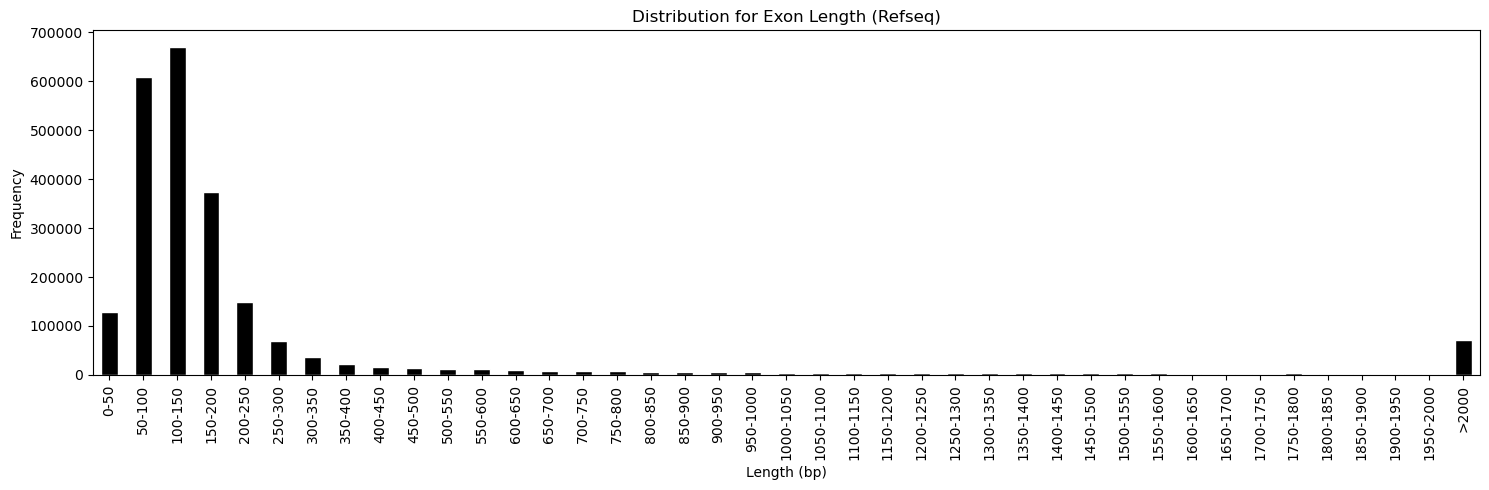

In [15]:
exon_lengths = refseq_df[refseq_df['type'] == 'exon']['length']

bin_edges = list(range(0, 2001, 50)) + [10000]
bin_labels = [f"{i}-{i+50}" for i in range(0, 2000, 50)] + ['>2000']
binned = pd.cut(exon_lengths, bins=bin_edges, labels=bin_labels, right=True)

bin_counts = binned.value_counts(sort=False)

plt.figure(figsize=(15, 5))
bin_counts.plot(kind='bar', color='black', edgecolor='white')
plt.xlabel("Length (bp)")
plt.ylabel("Frequency")
plt.title("Distribution for Exon Length (Refseq)")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [16]:
min(exon_lengths), max(exon_lengths)

(0, 91666)

### Plot the distribution of the length of introns.

Data Source: GENCODE

In [17]:
gencode_introns_df = gencode_df[gencode_df['type'] == 'exon'].reset_index().drop('index', axis=1)[['transcript_id', 'start', 'end']]
gencode_introns_df = gencode_introns_df.sort_values(['transcript_id', 'start']).reset_index().drop('index', axis=1)
gencode_introns_df = gencode_introns_df.groupby('transcript_id').agg(list)

In [18]:
introns = []
i = 0
for each in gencode_introns_df.itertuples():
    _, start, end = each
    start = pd.Series(start + [0])
    end = pd.Series([0] + end)
    introns += list(start-end)[1:-1]

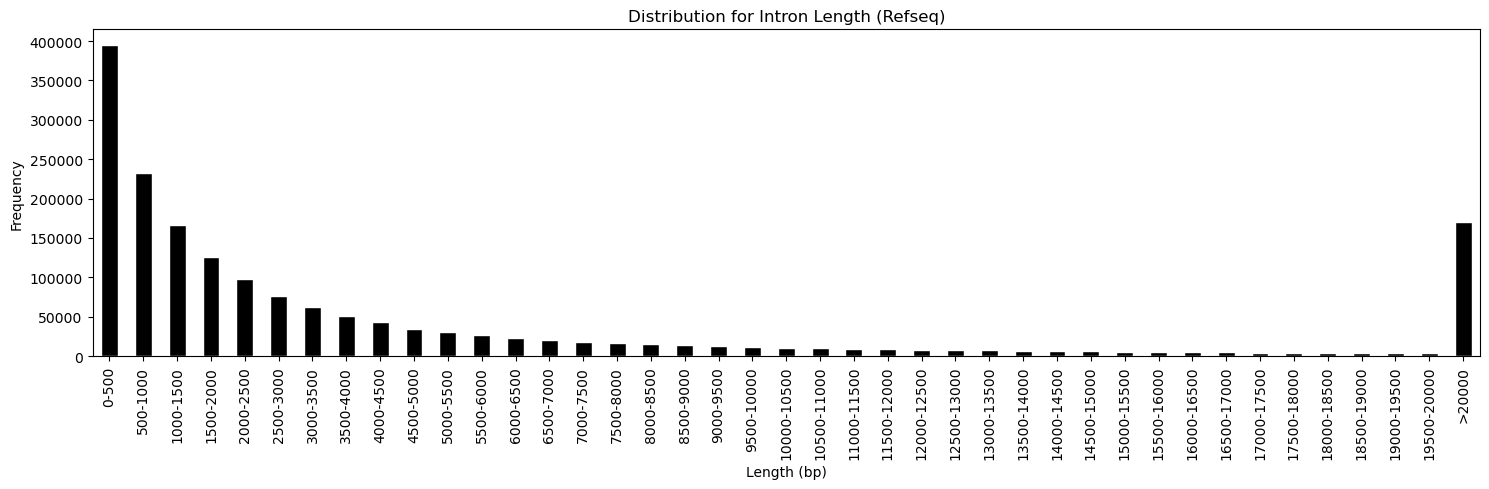

In [19]:
intron_lengths = pd.Series(introns)

bin_edges = list(range(0, 20001, 500)) + [2_000_000]
bin_labels = [f"{i}-{i+500}" for i in range(0, 20000, 500)] + ['>20000']
binned = pd.cut(intron_lengths, bins=bin_edges, labels=bin_labels, right=True)

bin_counts = binned.value_counts(sort=False)

plt.figure(figsize=(15, 5))
bin_counts.plot(kind='bar', color='black', edgecolor='white')
plt.xlabel("Length (bp)")
plt.ylabel("Frequency")
plt.title("Distribution for Intron Length (Refseq)")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [20]:
min(intron_lengths), max(intron_lengths)

(2, 1240121)

Data Source: RefSeq (NHBI)

In [21]:
refseq_introns_df = refseq_df[refseq_df['type'] == 'exon'].reset_index().drop('index', axis=1)[['transcript_id', 'start', 'end']]
refseq_introns_df = refseq_introns_df.sort_values(['transcript_id', 'start']).reset_index().drop('index', axis=1)
refseq_introns_df = refseq_introns_df.groupby('transcript_id').agg(list)

In [22]:
introns = []
i = 0
for each in refseq_introns_df.itertuples():
    _, start, end = each
    start = pd.Series(start + [0])
    end = pd.Series([0] + end)
    introns += list(start-end)[1:-1]

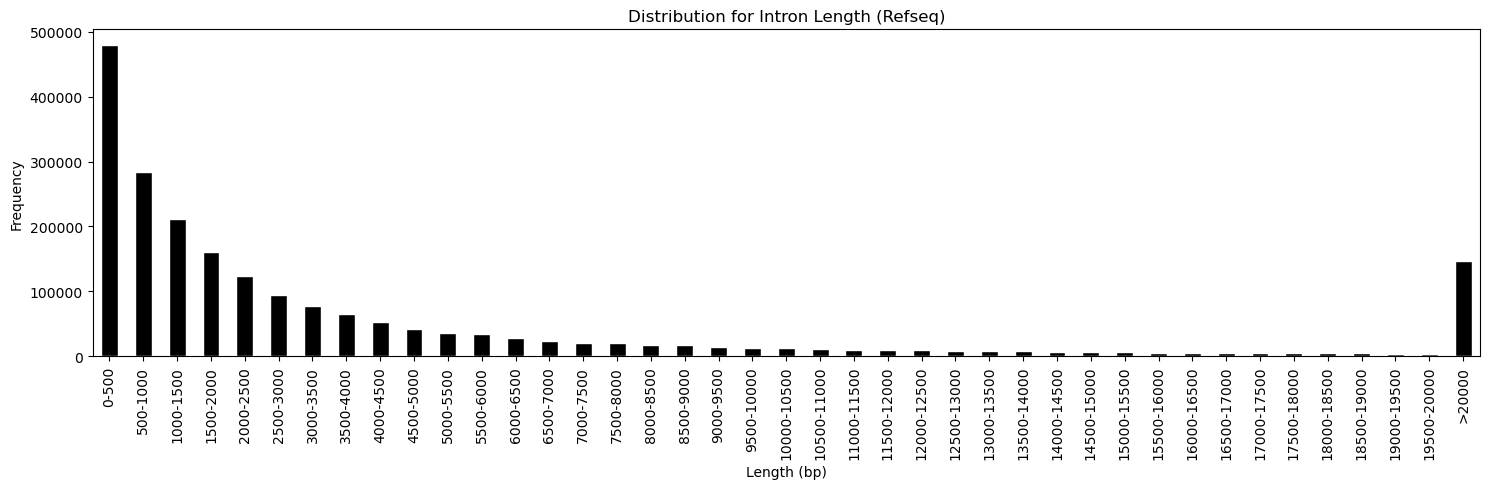

In [23]:
intron_lengths = pd.Series(introns)

bin_edges = list(range(0, 20001, 500)) + [2_000_000]
bin_labels = [f"{i}-{i+500}" for i in range(0, 20000, 500)] + ['>20000']
binned = pd.cut(intron_lengths, bins=bin_edges, labels=bin_labels, right=True)

bin_counts = binned.value_counts(sort=False)

plt.figure(figsize=(15, 5))
bin_counts.plot(kind='bar', color='black', edgecolor='white')
plt.xlabel("Length (bp)")
plt.ylabel("Frequency")
plt.title("Distribution for Intron Length (Refseq)")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [24]:
min(intron_lengths), max(intron_lengths)

(2, 1160412)

## Part 2. Greatest hits of the human genome

Although maybe a bit outdated, **[Dolgin, 2017]** compiled a list of the top 10 most studied genes in the human genome. Choose 3 out of the 10; and for each gene, answer the following questions:

1. **Where is it located in the genome, based on hg38 reference genome coordinates?**
2. **In which human tissues is the gene known to be expressed?**
3. **How many gene isoforms (alternatively spliced mRNAs) are known for each gene?**
4. **What is the average length of exons and average length of introns, across all isoforms?**
5. **How many protein isoforms are known for each gene?**
6. **What functions of the genes/proteins are known?**

Elie Dolgin. The most popular genes in the human genome. Nature, 551(7681):427–431, November 2017.

### Selected Genes
1. **TP53**
2. **TNF**
3. **EGFR**

### Where is it located in the genome, based on hg38 reference genome coordinates?

In [7]:
query = """
    SELECT seqid, SUBSTRING(json_extract(attributes, '$.gene_id'), 3, LENGTH(json_extract(attributes, '$.gene_id'))-4) as gene_id, 
    SUBSTRING(json_extract(attributes, '$.gene'), 3, LENGTH(json_extract(attributes, '$.gene'))-4) as gene,
    json_extract(attributes, '$.transcript_id') as transcript_id, featuretype as type, start, end FROM features
    WHERE json_extract(attributes, '$.gene')='["TP53"]'
    OR json_extract(attributes, '$.gene')='["TNF"]'
    OR json_extract(attributes, '$.gene')='["EGFR"]'
"""
genome_3_df = pd.read_sql(query, refseq.conn)

TP53 location

In [8]:
tp53_df = genome_3_df[(genome_3_df['type'] == 'transcript') & (genome_3_df['gene'] == 'TP53')]
tp53_df

,seqid,gene_id,gene,transcript_id,type,start,end
556,NC_000017.11,TP53,TP53,"[""NR_176326.1""]",transcript,7668421,7687490
567,NC_000017.11,TP53,TP53,"[""NM_001276761.3""]",transcript,7668421,7687490
589,NC_000017.11,TP53,TP53,"[""NM_001126112.3""]",transcript,7668421,7687490
613,NC_000017.11,TP53,TP53,"[""NM_001407269.1""]",transcript,7668421,7687490
635,NC_000017.11,TP53,TP53,"[""NM_001407268.1""]",transcript,7668421,7687490
659,NC_000017.11,TP53,TP53,"[""NM_000546.6""]",transcript,7668421,7687490
683,NC_000017.11,TP53,TP53,"[""NM_001276760.3""]",transcript,7668421,7687490
705,NC_000017.11,TP53,TP53,"[""NM_001276695.3""]",transcript,7668421,7687490
727,NC_000017.11,TP53,TP53,"[""NM_001126113.3""]",transcript,7668421,7687490
751,NC_000017.11,TP53,TP53,"[""NM_001276696.3""]",transcript,7668421,7687490


TNF location

In [9]:
tnf_df = genome_3_df[(genome_3_df['type'] == 'transcript') & (genome_3_df['gene'] == 'TNF')]
tnf_df

,seqid,gene_id,gene,transcript_id,type,start,end
1,NC_000006.12,TNF,TNF,"[""NM_000594.4""]",transcript,31575565,31578336
1107,NT_167244.2,TNF_1,TNF,"[""NM_000594.4_1""]",transcript,2909108,2910915
1116,NT_113891.3,TNF_2,TNF,"[""NM_000594.4_2""]",transcript,3052852,3055623
1128,NT_167245.2,TNF_3,TNF,"[""NM_000594.4_3""]",transcript,2823298,2826069
1140,NT_167246.2,TNF_4,TNF,"[""NM_000594.4_4""]",transcript,2880606,2883377
1152,NT_167247.2,TNF_5,TNF,"[""NM_000594.4_5""]",transcript,2917463,2920234
1164,NT_167248.2,TNF_6,TNF,"[""NM_000594.4_6""]",transcript,2831384,2834157
1176,NT_167249.2,TNF_7,TNF,"[""NM_000594.4_7""]",transcript,2874845,2877616


EGFR location

In [10]:
egfr_df = genome_3_df[(genome_3_df['type'] == 'transcript') & (genome_3_df['gene'] == 'EGFR')]
egfr_df

,seqid,gene_id,gene,transcript_id,type,start,end
13,NC_000007.14,EGFR,EGFR,"[""NM_005228.5""]",transcript,55019017,55211628
72,NC_000007.14,EGFR,EGFR,"[""NM_001346899.2""]",transcript,55019017,55211628
129,NC_000007.14,EGFR,EGFR,"[""NM_001346941.2""]",transcript,55019017,55211628
176,NC_000007.14,EGFR,EGFR,"[""NM_001346898.2""]",transcript,55019017,55203076
233,NC_000007.14,EGFR,EGFR,"[""NM_001346897.2""]",transcript,55019017,55203076
288,NC_000007.14,EGFR,EGFR,"[""NM_201284.2""]",transcript,55019017,55171037
323,NC_000007.14,EGFR,EGFR,"[""NM_201282.2""]",transcript,55019017,55168635
358,NC_000007.14,EGFR,EGFR,"[""NM_201283.2""]",transcript,55019017,55156939
381,NC_000007.14,EGFR,EGFR,"[""XM_047419953.1""]",transcript,55080469,55211628
439,NC_000007.14,EGFR,EGFR,"[""XM_047419952.1""]",transcript,55095532,55211628


### In which human tissues is the gene known to be expressed ?

### TP53

![TP53](https://i.ibb.co/wh7Z2Z3d/image.png)

### TNF
![TNF Expression](https://i.ibb.co/cSzq3QZy/image.png)

### EGFR
![EGFR RNA Expression](https://i.ibb.co/jv5nhjrB/image.png)

### How many gene isoforms (alternatively spliced mRNAs) are known for each gene?



TP53 Isoforms

In [142]:
tp53_df['transcript_id'].nunique()

26

TNF Isoforms

In [143]:
tnf_df['transcript_id'].nunique()

8

EGFR Isoforms

In [144]:
egfr_df['transcript_id'].nunique()

11

### What is the average length of exons and average length of introns, across all isoforms?

In [259]:
genome_3_df['length'] = genome_3_df['end'] - genome_3_df['start']
exons_df = genome_3_df[(genome_3_df['type'] == 'exon')][['gene','transcript_id', 'length']]
exons_mean_df = exons_df.groupby(['gene','transcript_id']).mean('length')
introns_df = genome_3_df[(genome_3_df['type'] == 'exon')][['gene','transcript_id', 'start', 'end']]
introns_df = introns_df.sort_values(['gene','transcript_id', 'start', 'end'])
introns_df = introns_df.groupby(['gene','transcript_id']).agg(list)

In [264]:
def get_intron_mean(gene, introns_df):
    intron_mean = []
    for each in introns_df.loc[gene].itertuples():
        _, start, end = each
        start = pd.Series(start + [0])
        end = pd.Series([0] + end)
        introns = start - end
        intron_mean.append(introns[1:-1].mean())
    return pd.Series(intron_mean).mean()

TP53 Average Exon & Intron Length

In [266]:
print(f"Average Exon Length: {exons_mean_df.loc['TP53']['length'].mean():.2f}") 
print(f"Average Intron Length: {get_intron_mean('TP53', introns_df):.2f}") 

Average Exon Length: 235.31
Average Intron Length: 1167.77


TNF Average Exon & Intron Length

In [267]:
print(f"Average Exon Length: {exons_mean_df.loc['TNF']['length'].mean():.2f}") 
print(f"Average Intron Length: {get_intron_mean('TNF', introns_df):.2f}") 

Average Exon Length: 421.06
Average Intron Length: 350.67


EGFR Average Exon & Intron Length

In [268]:
print(f"Average Exon Length: {exons_mean_df.loc['EGFR']['length'].mean():.2f}")
print(f"Average Intron Length: {get_intron_mean('EGFR', introns_df):.2f}") 

Average Exon Length: 395.23
Average Intron Length: 7452.88


### How many protein isoforms are known for each gene?

### What functions of the genes/proteins are known?

Insert Answer